# Inception v3

In [3]:
#torchd
import torch 
import torch.nn as nn
import torch.optim as optim  
import torchvision

import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
) 

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
# from PIL import Image
import time

warnings.filterwarnings("ignore")

from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

from data_loading_functions import split_train_test_loaders, show_img

# Load Data and Preprocessing: Inception v3

In [4]:
dataset_path = '.\\Combined_data'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
train_data
actual labels: ['Normal', 'Lung_Opacity', 'Normal', 'COVID']
numerical labels: tensor([2, 1, 2, 0])


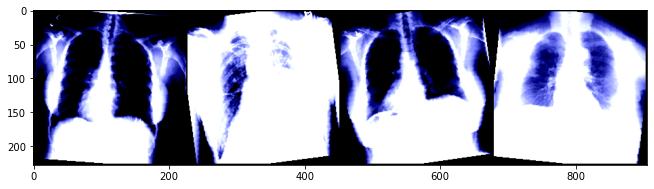

In [13]:
print('train_data')
show_img(datas[0])

In [14]:
print(f'Length of Training: {len(datas[0])}')
print(f'Length of Validation: {len(datas[1])}')
print(f'Length of Testing: {len(datas[2])}')

Length of Training: 21658
Length of Validation: 2708
Length of Testing: 2707


# Load Pretrained Inceptionv2

In [5]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

In [6]:
model = torchvision.models.inception_v3(pretrained=True)
# model
model.classifier = nn.Linear(2048, 4)
model.classifier

Linear(in_features=2048, out_features=4, bias=True)

In [7]:
from cnn_finetune import make_model

model = make_model('inceptionresnetv2', num_classes=4, pretrained=True, pool=nn.AdaptiveMaxPool2d(1))

In [16]:
for param in [model._classifier]:
  param.requires_grad = True

for param in model._features:
  param.requires_grad = False


In [27]:
torch.manual_seed(RANDOM_SEED)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(num_epochs = NUM_EPOCHS, model = model, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/010 | Batch 0000/0339 | Loss: 1.4706


KeyboardInterrupt: 

# Evaluation: Inceptionv3


In [ ]:
plt.plot(minibatch_loss_list, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [ ]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=train_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {train_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')